In [1]:
import torch
!pip install pyro-ppl
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import pyro.distributions as dist
import pyro
from torch.autograd import Variable
from pyro.infer.autoguide import *
from pyro.infer.mcmc import NUTS
from pyro.infer.mcmc.api import MCMC
from torch.distributions import constraints
from pyro import poutine

     |████████████████████████████████| 378kB 9.0MB/s 
     |████████████████████████████████| 61kB 5.8MB/s 
  Found existing installation: tqdm 4.28.1
    Uninstalling tqdm-4.28.1:
      Successfully uninstalled tqdm-4.28.1


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive
/gdrive/My Drive
/gdrive/My Drive/Colab Notebooks
     time  sunspot.year
0  1700.5           8.3
1  1701.5          18.3
2  1702.5          26.7
3  1703.5          38.3
4  1704.5          60.0


(array([16., 25., 25., 21., 10., 16., 14.,  8., 16., 13.,  9., 16.,  8.,
         7., 10., 14.,  9.,  6.,  7.,  8.,  7.,  6.,  5.,  1.,  5.,  6.,
         2.,  5.,  5.,  3.,  3.,  3.,  4.,  2.,  1.,  0.,  0.,  0.,  2.,
         1.]),
 array([  0.    ,   6.7325,  13.465 ,  20.1975,  26.93  ,  33.6625,
         40.395 ,  47.1275,  53.86  ,  60.5925,  67.325 ,  74.0575,
         80.79  ,  87.5225,  94.255 , 100.9875, 107.72  , 114.4525,
        121.185 , 127.9175, 134.65  , 141.3825, 148.115 , 154.8475,
        161.58  , 168.3125, 175.045 , 181.7775, 188.51  , 195.2425,
        201.975 , 208.7075, 215.44  , 222.1725, 228.905 , 235.6375,
        242.37  , 249.1025, 255.835 , 262.5675, 269.3   ]),
 <a list of 40 Patch objects>)

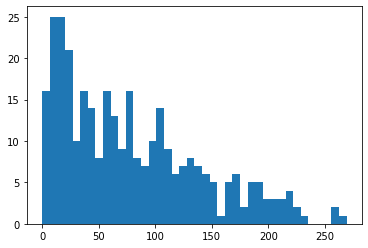

In [2]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive
%cd My\ Drive
%cd Colab\ Notebooks

df = pd.read_csv('sunspot.csv', sep=';', names=['time', 'sunspot.year'], usecols=[0, 1])
print (df.head())

plt.hist(df['sunspot.year'].values, bins=40)

In [5]:
import time

N = df.shape[0]

data = torch.tensor(df['sunspot.year'].values, dtype=torch.float32)
def model(data):
    alpha0 = pyro.sample('alpha', dist.Gamma(2, 0.5))
    # alpha0 = 2.
    cluster_rates = {}  
    crp_counts = []  # build this incrementally
    for i in range(len(data)):
        # sample from a CRP
        weights = torch.tensor(crp_counts + [alpha0], dtype=torch.float32) 
        weights /= weights.sum()
        crp_weights = pyro.param("weights_{}".format(i), Variable(weights), constraint=constraints.simplex)
        # print (crp_weights)

        zi = pyro.sample("z_{}".format(i), dist.Categorical(crp_weights))
        print(zi)
        zi = zi.item() 

        if zi >= len(crp_counts):
            crp_counts.append(1)  # sit at a new table
        else:
            crp_counts[zi] += 1  # sit at an existing table

        if zi not in cluster_rates.keys():
            cluster_rates[zi] = pyro.sample("lambda_{}".format(zi), dist.Uniform(0, 200))
        lambda_i = cluster_rates[zi]
        pyro.sample("obs_{}".format(i), dist.Poisson(lambda_i), obs=data[i])


nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel,
            num_samples=1000,
            warmup_steps=1000,
            num_chains=1)
mcmc.run(data)
mcmc.summary(prob=0.5)



Warmup:   0%|          | 0/2000 [00:00, ?it/s]

tensor(0)
tensor(1)
tensor(2)
tensor(3)
tensor(1)
tensor(2)
tensor(1)
tensor(3)
tensor(6)
tensor(6)
tensor(2)
tensor(7)
tensor(5)
tensor(0)
tensor(0)
tensor(2)
tensor(9)
tensor(8)
tensor(0)
tensor(8)
tensor(1)
tensor(7)
tensor(8)
tensor(8)
tensor(1)
tensor(0)
tensor(1)
tensor(9)
tensor(1)
tensor(4)
tensor(0)
tensor(2)
tensor(1)
tensor(8)
tensor(10)
tensor(1)
tensor(4)
tensor(2)
tensor(2)
tensor(3)
tensor(1)
tensor(7)
tensor(3)
tensor(6)
tensor(2)
tensor(0)
tensor(6)
tensor(8)
tensor(0)
tensor(4)
tensor(1)
tensor(0)
tensor(1)
tensor(8)
tensor(1)
tensor(1)
tensor(3)
tensor(8)
tensor(1)
tensor(8)
tensor(2)
tensor(0)
tensor(10)
tensor(4)
tensor(2)
tensor(2)
tensor(0)
tensor(8)
tensor(2)
tensor(7)
tensor(2)
tensor(4)
tensor(2)
tensor(8)
tensor(0)
tensor(10)
tensor(10)
tensor(1)
tensor(2)
tensor(3)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(6)
tensor(6)
tensor(1)
tensor(2)
tensor(5)
tensor(4)
tensor(1)
tensor(2)
tensor(1)
tensor(0)
tensor(8)
tensor(1)
tensor

ValueError: ignored

In [0]:
post = guide.get_posterior()

# print (pyro.param('weights_318'))

# print (post.__dict__)

print (post.transforms[0]._inverse(post.sample()))
# print (post.sample())

tensor([9.0224e-01, 1.9303e-02, 3.8258e-03, 4.3883e-03, 8.7918e-05, 2.3445e-04,
        1.2411e-03, 2.2590e-03, 8.7918e-05, 6.2304e-02, 1.1887e-03, 4.3959e-05,
        1.4653e-04, 1.4653e-05, 1.4653e-05, 1.4653e-05, 1.4653e-05, 1.4653e-05,
        2.5773e-03], grad_fn=<DivBackward0>)
tensor([ 1.0144e+00, -3.5299e-01, -1.1869e+00, -1.1496e+00,  6.8926e-02,
        -1.6430e+00,  8.0017e-02, -4.3675e-01, -3.6981e-01, -1.2241e+00,
        -2.7404e-01, -2.1751e-01,  1.3451e+00,  8.1884e-01, -1.1512e+00,
        -1.6906e+00, -9.4966e-05, -5.3308e-01,  1.6007e+00],
       grad_fn=<StackBackward>)


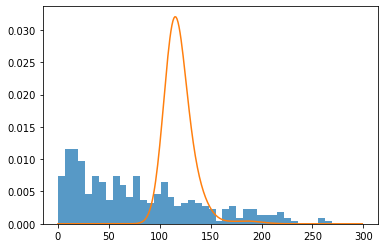

In [0]:
# print(pyro.get_param_store())

from scipy.stats import poisson

X = np.arange(0, 300)

# print (pyro.param('weights_318').detach().numpy())
# print ([pyro.param('auto_lambda_{}'.format(i)).detach().item() for i in range(10)])

def mop(X):
  weights = pyro.param('weights_318').detach().numpy()
  # rates = [pyro.param('auto_lambda_{}'.format(i)).detach().item() for i in range(len(weights) - 1)]
  rates = [i.detach().item() for i in list(cluster_rates.values())]
  return sum( [weights[i] * poisson.pmf(X, rates[i]) for i in range(len(weights))] )


Y = mop(X)
# print(Y)
plt.hist(data, bins=40, density=True, lw=0, alpha=0.75);
plt.plot(X, Y)
plt.show()
